In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision.datasets.utils import download_url

url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
file_path = './kagglecatsanddogs_5340.zip'

download_url(url, root='./data', filename='kagglecatsanddogs_5340.zip', md5=None)  # Provide the directory where you want to save the file and the file name

100%|██████████| 824887076/824887076 [00:11<00:00, 74041202.79it/s]


In [6]:
import zipfile

zip_file_path = './data/kagglecatsanddogs_5340.zip'
extract_folder = './data'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [7]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("./data/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


#### Normalizing the data + creating augmentation data

In [8]:
from torchvision import datasets, transforms

data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((180,180)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# data_transform = transforms.ToTensor()

dataset = datasets.ImageFolder(root='./data/PetImages',
                                           transform=data_transform)


In [9]:
len(dataset.targets)

23410

In [12]:
type(dataset)

torchvision.datasets.folder.ImageFolder

#### train/test splitting the data and then dataloader

In [13]:
# splitting the data into train and test

from torch.utils.data import random_split
train_num = int(0.8*len(dataset))
test_num = (len(dataset) - train_num)
train_dataset, test_dataset = random_split(dataset, [train_num, test_num])

In [14]:
# passing the data into dataloader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
print(len(train_dataset))
print(len(train_loader))

18728
586


#### visualizing the data

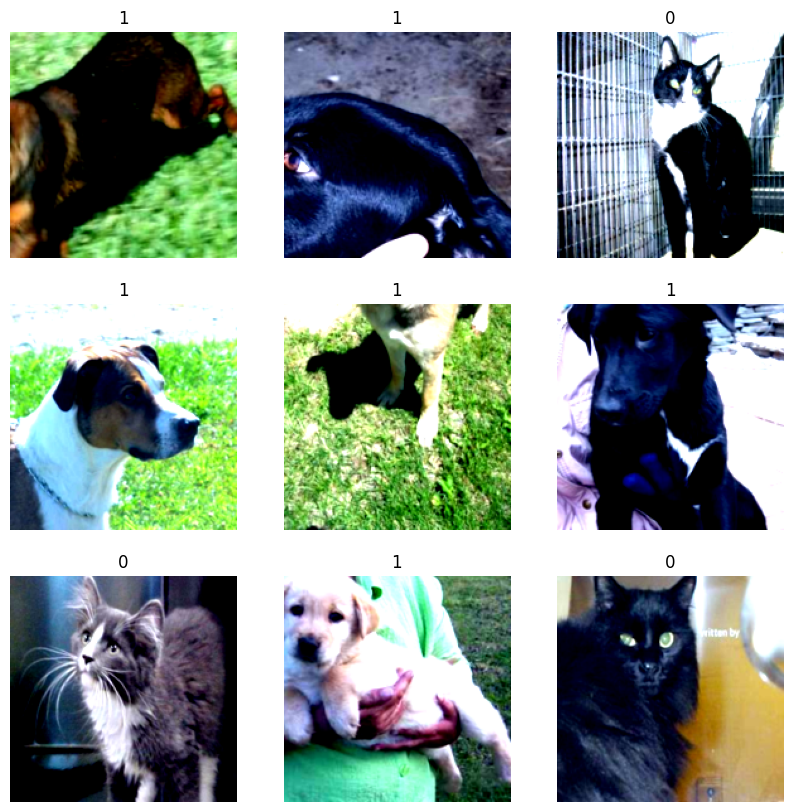

In [16]:
plt.figure(figsize=(10, 10))

for images, labels in train_loader:
        for i in range(9):
                ax = plt.subplot(3,3,i+1)
                image = images[i] / 2 + 0.5
                # plt.imshow(np.transpose(image.numpy(), (1,2,0)))
                plt.imshow(np.transpose(image.numpy(), (1,2,0)))
                plt.title(int(labels[i]))
                plt.axis('off')
        break
plt.show()

#### model building

In [17]:
# checking data shape:
# data, label = dataset[0]
# data.shape

data, _ = next(iter(train_loader))
data.shape

torch.Size([32, 3, 180, 180])

In [18]:
class seperable(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, *args, **kwargs):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=(3,3), padding=(1,1), groups=in_channels)
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=(1,1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.depthwise(x)
        x = self.pointwise(x)
        return(x)

test_data = torch.rand(size=(1,128, 90, 90))
test_model = seperable(128, 256)
test_model(test_data).size()

torch.Size([1, 256, 90, 90])

In [19]:
class layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.relu = nn.ReLU()
        self.seperable1 = seperable(in_channels, out_channels)
        self.seperable2 = seperable(out_channels, out_channels)

        self.bn = nn.BatchNorm2d(out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.cn = nn.Conv2d(in_channels, out_channels,
                            kernel_size=1, stride=2)

    def forward(self, x):
        out = self.relu(x)
        out = self.seperable1(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.seperable2(out)
        out = self.bn(out)
        out = self.maxpool(out)
        conv = self.cn(x)

        return out + conv

test_data = torch.rand(size=(1,128, 90, 90))
test_model = layer(128, 256)
test_model(test_data).size()

torch.Size([1, 256, 45, 45])

In [20]:
class cnn(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # Rescaling ?
        self.layers = nn.ModuleList()

        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ))
        feature_maps = [128, 256, 512, 728]

        for idx, size in enumerate(feature_maps[:-1]):
          self.layers.append(layer(in_channels = size,
                                   out_channels= feature_maps[idx+1]))

        self.layers.append(nn.Sequential(
            nn.Conv2d(728, 1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            # nn.Dropout2d(p=0.2),
            nn.Flatten(),
            nn.Dropout1d(),
            nn.Linear(1024,1)
        ))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1024,1)

    def forward(self, x):
        # x = self.layers(x)   NOT working! Modulelist doesn't have forward method
        for layer in self.layers:
          x = layer(x)
        x = x.flatten()
        return (x)



test_data = torch.rand(size=(1,3, 180, 180))
test_model = cnn(3)
test_model(test_data)

# model = cnn(3)
# model(data)

tensor([-0.0032], grad_fn=<ViewBackward0>)

In [21]:
# model parameters

learning_rate = 1e-3
num_epochs = 20
batch_size = 32

model = cnn(3)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [22]:
# print(model)

In [ ]:
for epoch in range(num_epochs):
  model.to(device)
  train_losses = []   
  train_loss = 0.0       # for cumulative adding
  train_corrected = 0.0  
  model.train(True) 
 
  for batch_idx, (data, target) in enumerate(train_loader):  ## no need batch_idx
  # for data, target in train_loader:
    # if batch_idx > 1:
    #   break
    data = data.to(device)
    target = target.float().to(device)
    
    output = model(data)
    loss = criterion(output, target)  # one loss per each batch

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()  # adds up all losses of all batches for every epoch ()
    train_predict = (output>0).float()
    train_corrected += (train_predict == target).sum().item()
    train_losses.append(loss.item()) # lists all losses of all batches for every epoch () len=586

  train_accuracy = train_corrected/len(train_dataset)   # sum of all correct predictions each epoch /
                                                        # len of a dataset (=dataset within an epoch)

  train_loss /= len(train_loader) #   /=  his operator is an in-place division. It divides the value on the
  # left (train_loss) by the value on the right (len(train_loader)) and assigns the result back to train_loss


  # len(train_dataset) = 18728
  # len(train_loader) = 586   (18728/32)

  model.eval() 
  test_correct = 0  
  with torch.no_grad():
      for data, target in test_loader:
        data = data.to(device)
        target = target.float().to(device)
        # test_loss = criterion(output, target)  # test accuracy should be enough
        output = model(data)
        test_predict = (output>0).float()
        test_corrected += (test_predict == target).sum().item()

  test_accuracy = test_corrected/len(test_dataset)


  print(epoch, 'train_loss:', train_loss, 'train_accuracy:', train_accuracy, 'test_accuracy:', test_accuracy)
